In [35]:
import gymnasium as gym
from tqdm import tqdm
env = gym.make('Blackjack-v1', natural=False, sab=True)

In [36]:
class BlackJackAgent:

    def __init__(self,env):
        self.V = {}
        self.env = env

    def greedy_policy(self, state):
        if state[0] == 20 or state[0] == 21:
            return 0
        else:
            return 1

    def generate_episode(self):
        episode = []
        state,_ = self.env.reset()
        while True:
            action = self.greedy_policy(state)
            next_state, reward, terminated, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if terminated:
                break
        return episode
    

    def mc_prediction(self, num_episodes):
        returns = {}
        for _ in tqdm(range(num_episodes)):
            episode = self.generate_episode()
            G = 0
            for i, (state, _, reward) in enumerate(episode[::-1]):
                G = reward + G
                if state not in [x[0] for x in episode[::-1][len(episode)-i:]]:
                    if state not in self.V:
                        returns[state] = [G]
                    else:
                        returns[state].append(G)
                    self.V[state] = sum(returns[state])/len(returns[state])
        

In [38]:
agent = BlackJackAgent(env)
agent.mc_prediction(1000000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [11:25<00:00, 1458.07it/s]


In [40]:
def filter_states(V):
    usable_ace = {}
    no_usable_ace = {}
    for state in V:
        if state[2]:
            usable_ace[state] = V[state]
        else:
            no_usable_ace[state] = V[state]
    return usable_ace, no_usable_ace

In [41]:
usable_ace, no_usable_ace = filter_states(agent.V)


{(19, 6, 1): -0.5121951219512195, (21, 10, 1): 0.9128282393456737, (21, 2, 1): 0.9726430976430976, (20, 1, 1): 0.11478800413650465, (20, 7, 1): 0.7799586776859504, (20, 10, 1): 0.44349108459579034, (20, 2, 1): 0.6324655436447167, (21, 9, 1): 0.9868536371603857, (20, 6, 1): 0.7280042918454935, (21, 3, 1): 0.9761232906446712, (17, 3, 1): -0.525, (19, 10, 1): -0.6047397376216673, (21, 8, 1): 0.986689566337484, (21, 1, 1): 0.6691160579208991, (19, 5, 1): -0.5830508474576271, (21, 5, 1): 0.9728201782996303, (21, 7, 1): 0.9837310195227765, (15, 7, 1): -0.37755102040816324, (20, 8, 1): 0.8072159396876682, (21, 6, 1): 0.9766553480475382, (17, 4, 1): -0.5115384615384615, (18, 2, 1): -0.5314685314685315, (20, 9, 1): 0.7572347266881029, (16, 5, 1): -0.366120218579235, (21, 4, 1): 0.9790284613738498, (17, 8, 1): -0.41823899371069184, (17, 6, 1): -0.5261194029850746, (16, 6, 1): -0.4861878453038674, (19, 8, 1): -0.5062836624775583, (14, 9, 1): -0.20408163265306123, (18, 10, 1): -0.5536992840095465,

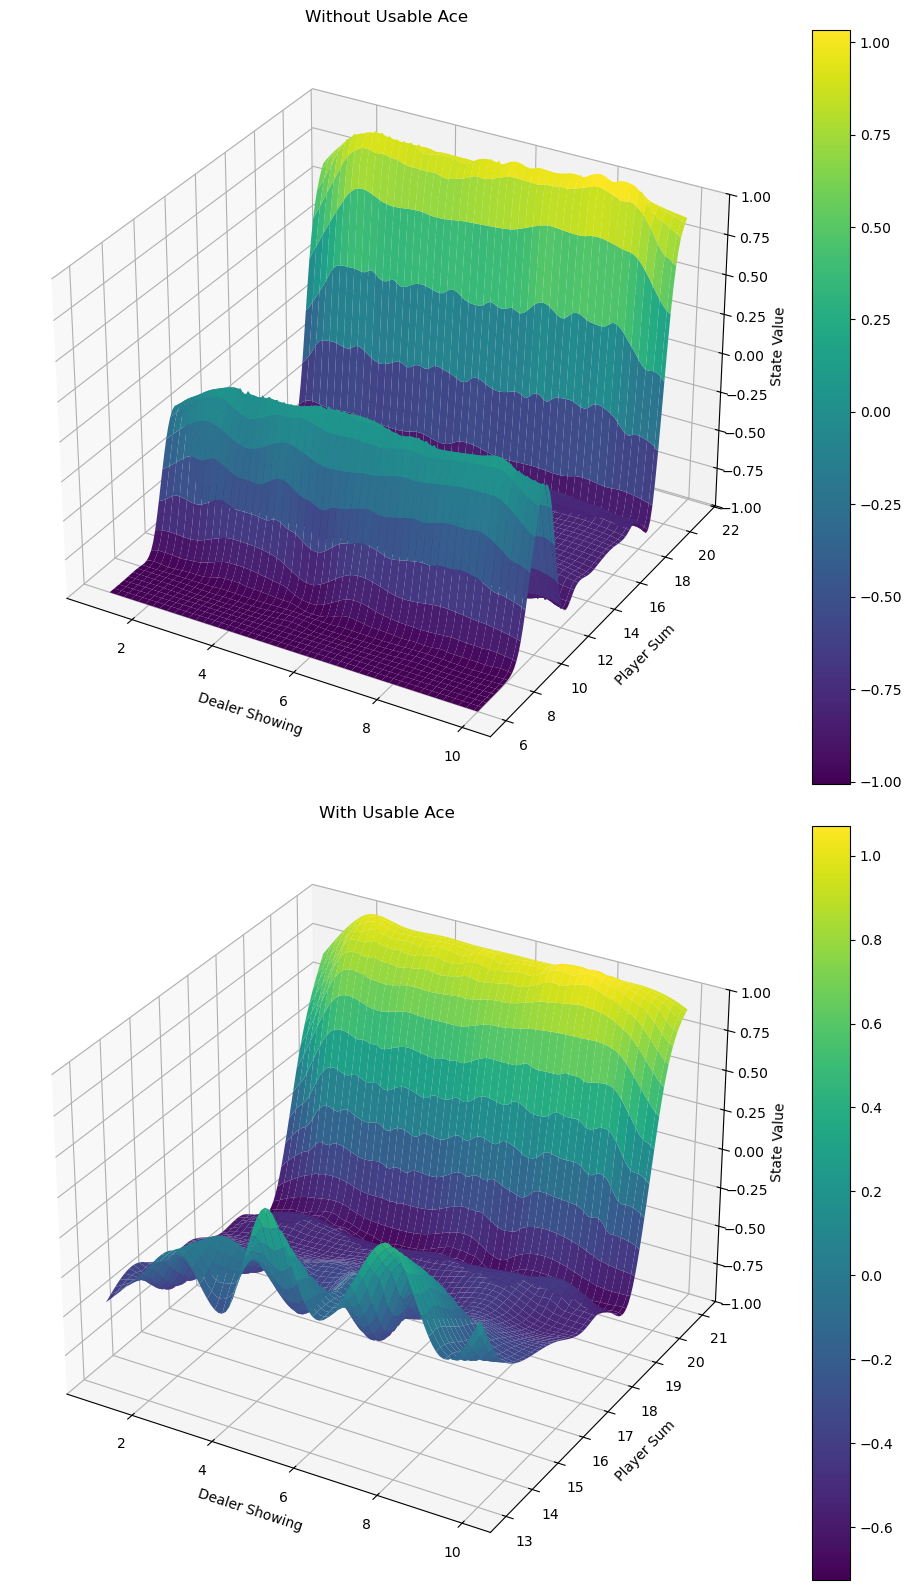

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def plot_value_function(usable_ace, no_usable_ace):
    # Create figure with two subplots
    fig, axes = plt.subplots(nrows=2, figsize=(10, 16), subplot_kw={'projection': '3d'})
    
    # Plot for no usable ace
    player_sum_no_ace = np.array([state[0] for state in no_usable_ace.keys()])
    dealer_showing_no_ace = np.array([state[1] for state in no_usable_ace.keys()])
    values_no_ace = np.array(list(no_usable_ace.values()))
    
    # Create meshgrid for interpolation - Note the order is switched here
    grid_x_no_ace, grid_y_no_ace = np.mgrid[min(dealer_showing_no_ace):max(dealer_showing_no_ace):100j,
                                           min(player_sum_no_ace):max(player_sum_no_ace):100j]
    grid_z_no_ace = griddata((dealer_showing_no_ace, player_sum_no_ace), 
                            values_no_ace, 
                            (grid_x_no_ace, grid_y_no_ace), 
                            method='cubic')
    
    # Plot surface for no usable ace
    surf_no_ace = axes[0].plot_surface(grid_x_no_ace, grid_y_no_ace, grid_z_no_ace, cmap='viridis')
    axes[0].set_title('Without Usable Ace')
    plt.colorbar(surf_no_ace, ax=axes[0])
    
    # Plot for usable ace
    player_sum_ace = np.array([state[0] for state in usable_ace.keys()])
    dealer_showing_ace = np.array([state[1] for state in usable_ace.keys()])
    values_ace = np.array(list(usable_ace.values()))
    
    # Create meshgrid for interpolation - Note the order is switched here
    grid_x_ace, grid_y_ace = np.mgrid[min(dealer_showing_ace):max(dealer_showing_ace):100j,
                                     min(player_sum_ace):max(player_sum_ace):100j]
    grid_z_ace = griddata((dealer_showing_ace, player_sum_ace), 
                         values_ace, 
                         (grid_x_ace, grid_y_ace), 
                         method='cubic')
    
    # Plot surface for usable ace
    surf_ace = axes[1].plot_surface(grid_x_ace, grid_y_ace, grid_z_ace, cmap='viridis')
    axes[1].set_title('With Usable Ace')
    plt.colorbar(surf_ace, ax=axes[1])
    
    # Set labels and limits for both plots
    for ax in axes:
        ax.set_xlabel('Dealer Showing')  # Switched label
        ax.set_ylabel('Player Sum')      # Switched label
        ax.set_zlabel('State Value')
        ax.set_zlim(-1, 1)
        
    plt.tight_layout()
    plt.show()

# Call the function with your filtered data
plot_value_function(usable_ace, no_usable_ace)